In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics

import numpy as np
from ortools.sat.python import cp_model

import seaborn as sns
import matplotlib.pyplot as plt

import time

In [2]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "00_instance.csv")

arrival_shifts_numb = 1
df_jssp, df_jobs_times = gen_jobs.create_jobs_for_shifts(df_instance, shift_count= arrival_shifts_numb, u_b_mmax= 0.94, 
                                                         shift_length = 1440, shuffle = True, job_seed= 50, arrival_seed = 120)
df_jobs_times

,Job,Arrival,Ready Time,Processing Time,Earliest End
0,Job_000,0,1440,395,1835
1,Job_001,48,1440,510,1950
2,Job_002,113,1440,568,2008
3,Job_003,157,1440,655,2095
4,Job_004,198,1440,393,1833
5,Job_005,401,1440,496,1936
6,Job_006,681,1440,416,1856
7,Job_007,810,1440,539,1979
8,Job_008,870,1440,597,2037
9,Job_009,885,1440,540,1980


In [3]:
df_jobs_times = gen_deadline.assign_deadlines_with_global_lognormal_mode(df_jobs_times, sigma=0.5, 
                                                                         basic_slack=60, seed=50, global_modus=2880)

df_jobs_times

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_000,0,1440,395,1835,2657
1,Job_001,48,1440,510,1950,6622
2,Job_002,113,1440,568,2008,2102
3,Job_003,157,1440,655,2095,5590
4,Job_004,198,1440,393,1833,2953
5,Job_005,401,1440,496,1936,4808
6,Job_006,681,1440,416,1856,4276
7,Job_007,810,1440,539,1979,2288
8,Job_008,870,1440,597,2037,7443
9,Job_009,885,1440,540,1980,18552


In [4]:
import pandas as pd
import random
from collections import defaultdict

def giffler_thompson_schedule(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    priority_rule: str = "SPT",
    log_on: bool = True
) -> pd.DataFrame:
    """
    Giffler-Thompson-Algorithmus mit Ready Time (für Planung) und Arrival (für Ausgabe).
    Rückgabe mit Lateness, Tardiness, Earliness.

    Rückgabe:
    - df_schedule: DataFrame mit Zeitplan und Auswertung
    - makespan: maximale Endzeit
    - total_abs_lateness: Summe der absoluten Lateness der letzten Operationen je Job
    """

    if log_on: 
        print(f'Giffler-Thompson-Algorithmus mit Prioritätsregel \"{priority_rule}\" gestartet ...\n')

    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    ready_time = df_arrivals_deadlines.set_index("Job")["Ready Time"].to_dict()
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_op_ready = {job: 0 for job in jobs}
    machine_available = {m: 0 for m in machines}
    job_op_index = {job: 0 for job in jobs}

    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    remaining = sum(len(v) for v in job_ops.values())

    while remaining > 0:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]
                est = max(job_op_ready[job], machine_available[m], ready_time[job])
                candidates.append((est, d, job, op_id, m))

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule == "EDF" or priority_rule == "EDD":
            selected = min(conflict_ops, key=lambda x: deadline[x[2]])  # x[2] ist der Job
        else:  # RANDOM oder unbekannt
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d

        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1
        remaining -= 1

    # Berechnung von Lateness, Tardiness, Earliness
    for row in result:
        job = row['Job']
        lateness_val = row['End'] - deadline[job]
        row.update({
            "Arrival": arrival[job],
            "Deadline": deadline[job],
            "Lateness": lateness_val,
            "Tardiness": max(0, lateness_val),
            "Earliness": max(0, -lateness_val)
        })

    df_schedule = pd.DataFrame(result).sort_values(['Start', 'Job', 'Operation']).reset_index(drop=True)

    last_ops = df_schedule.groupby("Job")["Operation"].max()
    last_op_index_tuples = list(zip(last_ops.index, last_ops.values))
    mask_last_ops = df_schedule.set_index(["Job", "Operation"]).index.isin(last_op_index_tuples)
    total_abs_lateness = df_schedule[mask_last_ops]["Lateness"].abs().sum()

    makespan = df_schedule['End'].max()

    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs            : {len(jobs)}")
        print(f"  Anzahl Maschinen       : {len(machines)}")
        print(f"  Anzahl Operationen     : {len(df_schedule)}")
        print(f"  Makespan               : {makespan}")
        print(f"  Summe Absolute Lateness: {total_abs_lateness}")

    return df_schedule, makespan, total_abs_lateness


### SPT

In [5]:
df_schedule, makespan, total_abs_lateness = giffler_thompson_schedule(
    df_jssp=df_jssp,
    df_arrivals_deadlines=df_jobs_times,
    priority_rule="SPT",
    log_on=True
)

last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

Giffler-Thompson-Algorithmus mit Prioritätsregel "SPT" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 17
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 170
  Makespan               : 2846
  Summe Absolute Lateness: 42152


label
0            12
0 - 120       2
120 - 240     0
240 - 360     0
360 - 480     1
480 - 600     0
600 - 720     1
720 - 840     1
>840          0
Name: count, dtype: int64

### EDD (EDF)

In [6]:
df_schedule, makespan, total_abs_lateness = giffler_thompson_schedule(
    df_jssp=df_jssp,
    df_arrivals_deadlines=df_jobs_times,
    priority_rule="EDF",
    log_on=True
)

df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "EDF" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 17
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 170
  Makespan               : 3102
  Summe Absolute Lateness: 36923


,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,Job_013,0,M2,1440,31,1471,1065,2196,-725,0,725
1,Job_015,0,M1,1440,46,1486,1299,2046,-560,0,560
2,Job_016,0,M0,1440,43,1483,1360,2543,-1060,0,1060
3,Job_007,0,M2,1471,31,1502,810,2288,-786,0,786
4,Job_013,1,M0,1483,86,1569,1065,2196,-627,0,627
...,...,...,...,...,...,...,...,...,...,...,...
165,Job_008,7,M7,2884,89,2973,870,7443,-4470,0,4470
166,Job_009,8,M4,2912,90,3002,885,18552,-15550,0,15550
167,Job_008,8,M4,3002,26,3028,870,7443,-4415,0,4415
168,Job_009,9,M7,3002,45,3047,885,18552,-15505,0,15505


In [7]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

label
0            16
0 - 120       0
120 - 240     1
240 - 360     0
360 - 480     0
480 - 600     0
600 - 720     0
720 - 840     0
>840          0
Name: count, dtype: int64

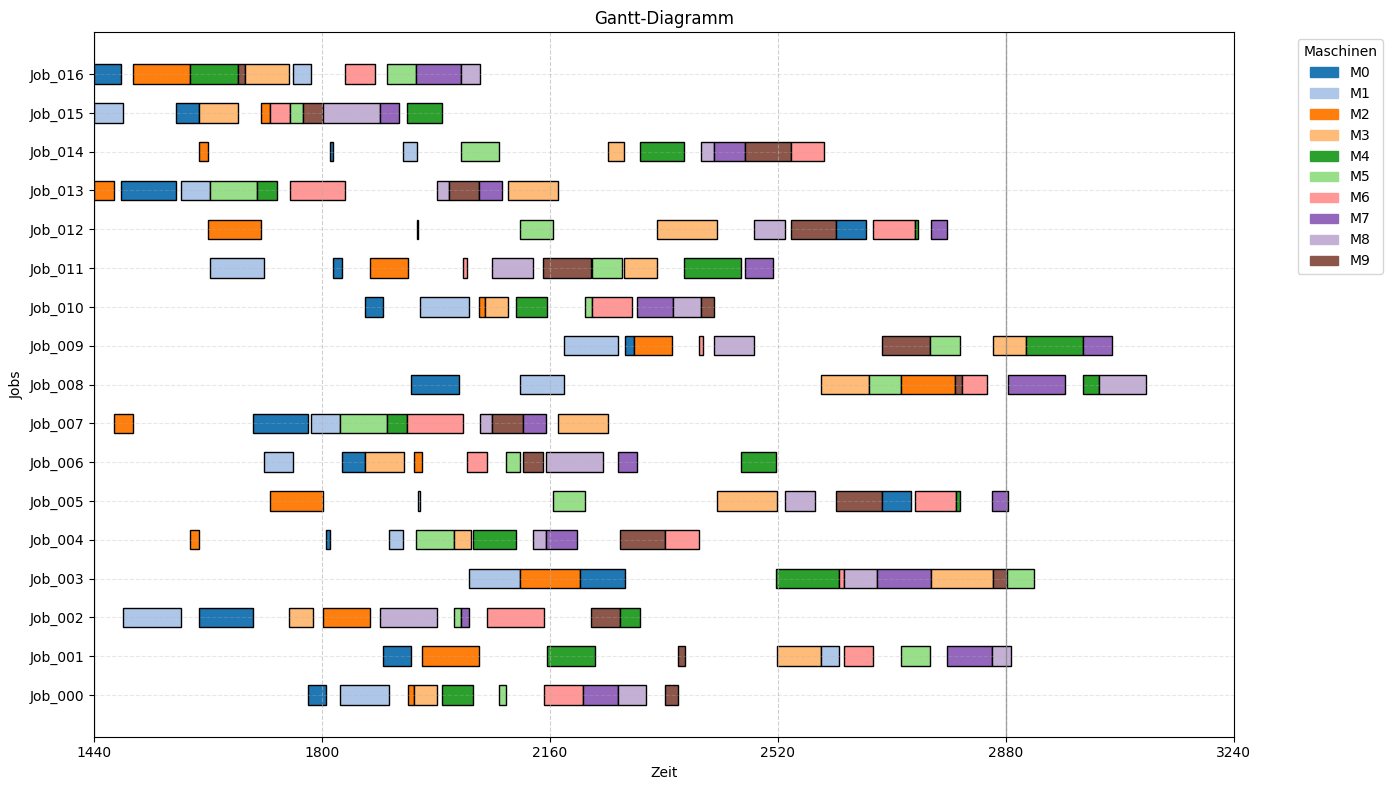

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [8]:
show.plot_gantt_jobs(df_schedule)

check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)